In [ ]:
!pip install -q roboflow ultralytics opencv-python-headless matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 132.6 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MMFZWHhSvylkZHBxlS7M")
project = rf.workspace("blue-halo").project("vegetation-segmentation")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to vegetation-segmentation-4 in yolov8:: 100%|██████████| 2148/2148 [00:01<00:00, 2137.19it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install ultralytics


In [ ]:
import os, random, glob, shutil, time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from ultralytics import YOLO

Get Image Count

In [ ]:
def count_images(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder) if f.lower().endswith((".jpg",".jpeg",".png"))])

train_img_path = os.path.join(dataset.location, "train", "images")
valid_img_path = os.path.join(dataset.location, "valid", "images")
test_img_path  = os.path.join(dataset.location, "test",  "images")

print("\n--- IMAGE COUNTS (before preprocessing) ---")
print("Train:", count_images(train_img_path))
print("Valid:", count_images(valid_img_path))
print("Test: ", count_images(test_img_path))


--- IMAGE COUNTS (before preprocessing) ---
Train: 945
Valid: 83
Test:  40


Convert YOLOv8 Segmentation Labels → Binary Masks

In [ ]:
def yolo_seg_to_mask(img_path, label_path, mask_out_path):
    img = cv2.imread(img_path)
    if img is None:
        return False
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 3:
                    continue
                try:
                    cls = int(float(parts[0]))
                    pts = list(map(float, parts[1:]))
                except:
                    continue
                if len(pts) % 2 != 0:
                    continue
                pts = np.array(pts).reshape(-1, 2)
                abs_pts = np.zeros_like(pts)
                abs_pts[:,0] = pts[:,0] * w
                abs_pts[:,1] = pts[:,1] * h
                abs_pts = abs_pts.astype(np.int32)
                if abs_pts.shape[0] >= 3:
                    cv2.fillPoly(mask, [abs_pts], color=1)   # fill with class 1 (vegetation)
    cv2.imwrite(mask_out_path, mask)
    return True

sets = ["train","valid","test"]
for s in sets:
    img_folder = os.path.join(dataset.location, s, "images")
    label_folder = os.path.join(dataset.location, s, "labels")
    mask_folder = os.path.join(dataset.location, s, "masks")
    os.makedirs(mask_folder, exist_ok=True)
    files = [f for f in os.listdir(img_folder) if f.lower().endswith((".jpg",".jpeg",".png"))]
    print(f"\nConverting labels to masks for {s}: {len(files)} images")
    for fn in tqdm(files):
        img_path = os.path.join(img_folder, fn)
        lbl_path = os.path.join(label_folder, os.path.splitext(fn)[0] + ".txt")
        mask_out = os.path.join(mask_folder, os.path.splitext(fn)[0] + ".png")
        yolo_seg_to_mask(img_path, lbl_path, mask_out)
print("Label → mask conversion complete.")



Converting labels to masks for train: 945 images


100%|██████████| 945/945 [00:11<00:00, 79.28it/s]



Converting labels to masks for valid: 83 images


100%|██████████| 83/83 [00:00<00:00, 106.68it/s]



Converting labels to masks for test: 40 images


100%|██████████| 40/40 [00:00<00:00, 104.95it/s]

Label → mask conversion complete.


Preprocessing functions (color, brightness safe, sharpening, augmentations, resize)

In [ ]:
def hist_equalize(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def random_brightness(img, limit=25):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.int32)
    val = random.randint(-limit, limit)
    hsv[:,:,2] = np.clip(hsv[:,:,2] + val, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def sharpen(img):
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return cv2.filter2D(img, -1, k)

def flip_h(img):
    return cv2.flip(img, 1)

def rotate_img(img, angle_range=(-10,10)):
    ang = random.uniform(angle_range[0], angle_range[1])
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), ang, 1)
    return cv2.warpAffine(img, M, (w, h))

def resize(img, size=(256,256)):
    return cv2.resize(img, size)

Apply preprocessing to train/valid/test images and save into new folder structure

In [ ]:
processed_root = os.path.join(dataset.location, "preprocessed")
if os.path.exists(processed_root):
    shutil.rmtree(processed_root)
for s in sets:
    src_img = os.path.join(dataset.location, s, "images")
    src_mask = os.path.join(dataset.location, s, "masks")
    dst_img = os.path.join(processed_root, s, "images")
    dst_mask = os.path.join(processed_root, s, "masks")
    os.makedirs(dst_img, exist_ok=True)
    os.makedirs(dst_mask, exist_ok=True)

print("\nApplying preprocessing (this shows counts and does transform).")
processed_counts = {"train":0,"valid":0,"test":0}
for s in sets:
    files = [f for f in os.listdir(os.path.join(dataset.location, s, "images")) if f.lower().endswith((".jpg",".jpeg",".png"))]
    print(f"\nProcessing set: {s} ({len(files)} images)")
    for fn in tqdm(files):
        src_img_path = os.path.join(dataset.location, s, "images", fn)
        src_mask_path = os.path.join(dataset.location, s, "masks", os.path.splitext(fn)[0] + ".png")
        dst_img_path = os.path.join(processed_root, s, "images", fn)
        dst_mask_path = os.path.join(processed_root, s, "masks", os.path.splitext(fn)[0] + ".png")

        img = cv2.imread(src_img_path)
        if img is None:
            continue

        # color & contrast
        img = hist_equalize(img)
        img = random_brightness(img, limit=25)
        img = sharpen(img)

        # augment/transform (random flip + rotation)
        if random.random() > 0.5:
            img = flip_h(img)
            # also flip mask
            mask = cv2.imread(src_mask_path, cv2.IMREAD_UNCHANGED)
            if mask is None:
                mask = np.zeros(img.shape[:2], dtype=np.uint8)
            mask = cv2.flip(mask, 1)
        else:
            mask = cv2.imread(src_mask_path, cv2.IMREAD_UNCHANGED)
            if mask is None:
                mask = np.zeros(img.shape[:2], dtype=np.uint8)

        img = rotate_img(img)
        mask = rotate_img(mask) if mask is not None else mask

        img = resize(img, size=(256,256))
        mask = cv2.resize(mask, (256,256), interpolation=cv2.INTER_NEAREST)

        cv2.imwrite(dst_img_path, img)
        cv2.imwrite(dst_mask_path, mask)

        processed_counts[s] += 1

print("\nPreprocessing finished. Processed counts:", processed_counts)


Applying preprocessing (this shows counts and does transform).

Processing set: train (945 images)


100%|██████████| 945/945 [00:53<00:00, 17.70it/s]



Processing set: valid (83 images)


100%|██████████| 83/83 [00:04<00:00, 17.97it/s]



Processing set: test (40 images)


100%|██████████| 40/40 [00:02<00:00, 19.72it/s]


Preprocessing finished. Processed counts: {'train': 945, 'valid': 83, 'test': 40}


 Display counts before/after

In [ ]:
print("\n--- SUMMARY IMAGE COUNTS ---")
print("Before preprocessing:")
print(" Train:", count_images(train_img_path))
print(" Valid:", count_images(valid_img_path))
print(" Test: ", count_images(test_img_path))
print("\nAfter preprocessing (processed images):")
print(" Train processed:", processed_counts["train"])
print(" Valid processed:", processed_counts["valid"])
print(" Test processed: ", processed_counts["test"])


--- SUMMARY IMAGE COUNTS ---
Before preprocessing:
 Train: 945
 Valid: 83
 Test:  40

After preprocessing (processed images):
 Train processed: 945
 Valid processed: 83
 Test processed:  40


Display 5 random samples (image + mask + unique classes)

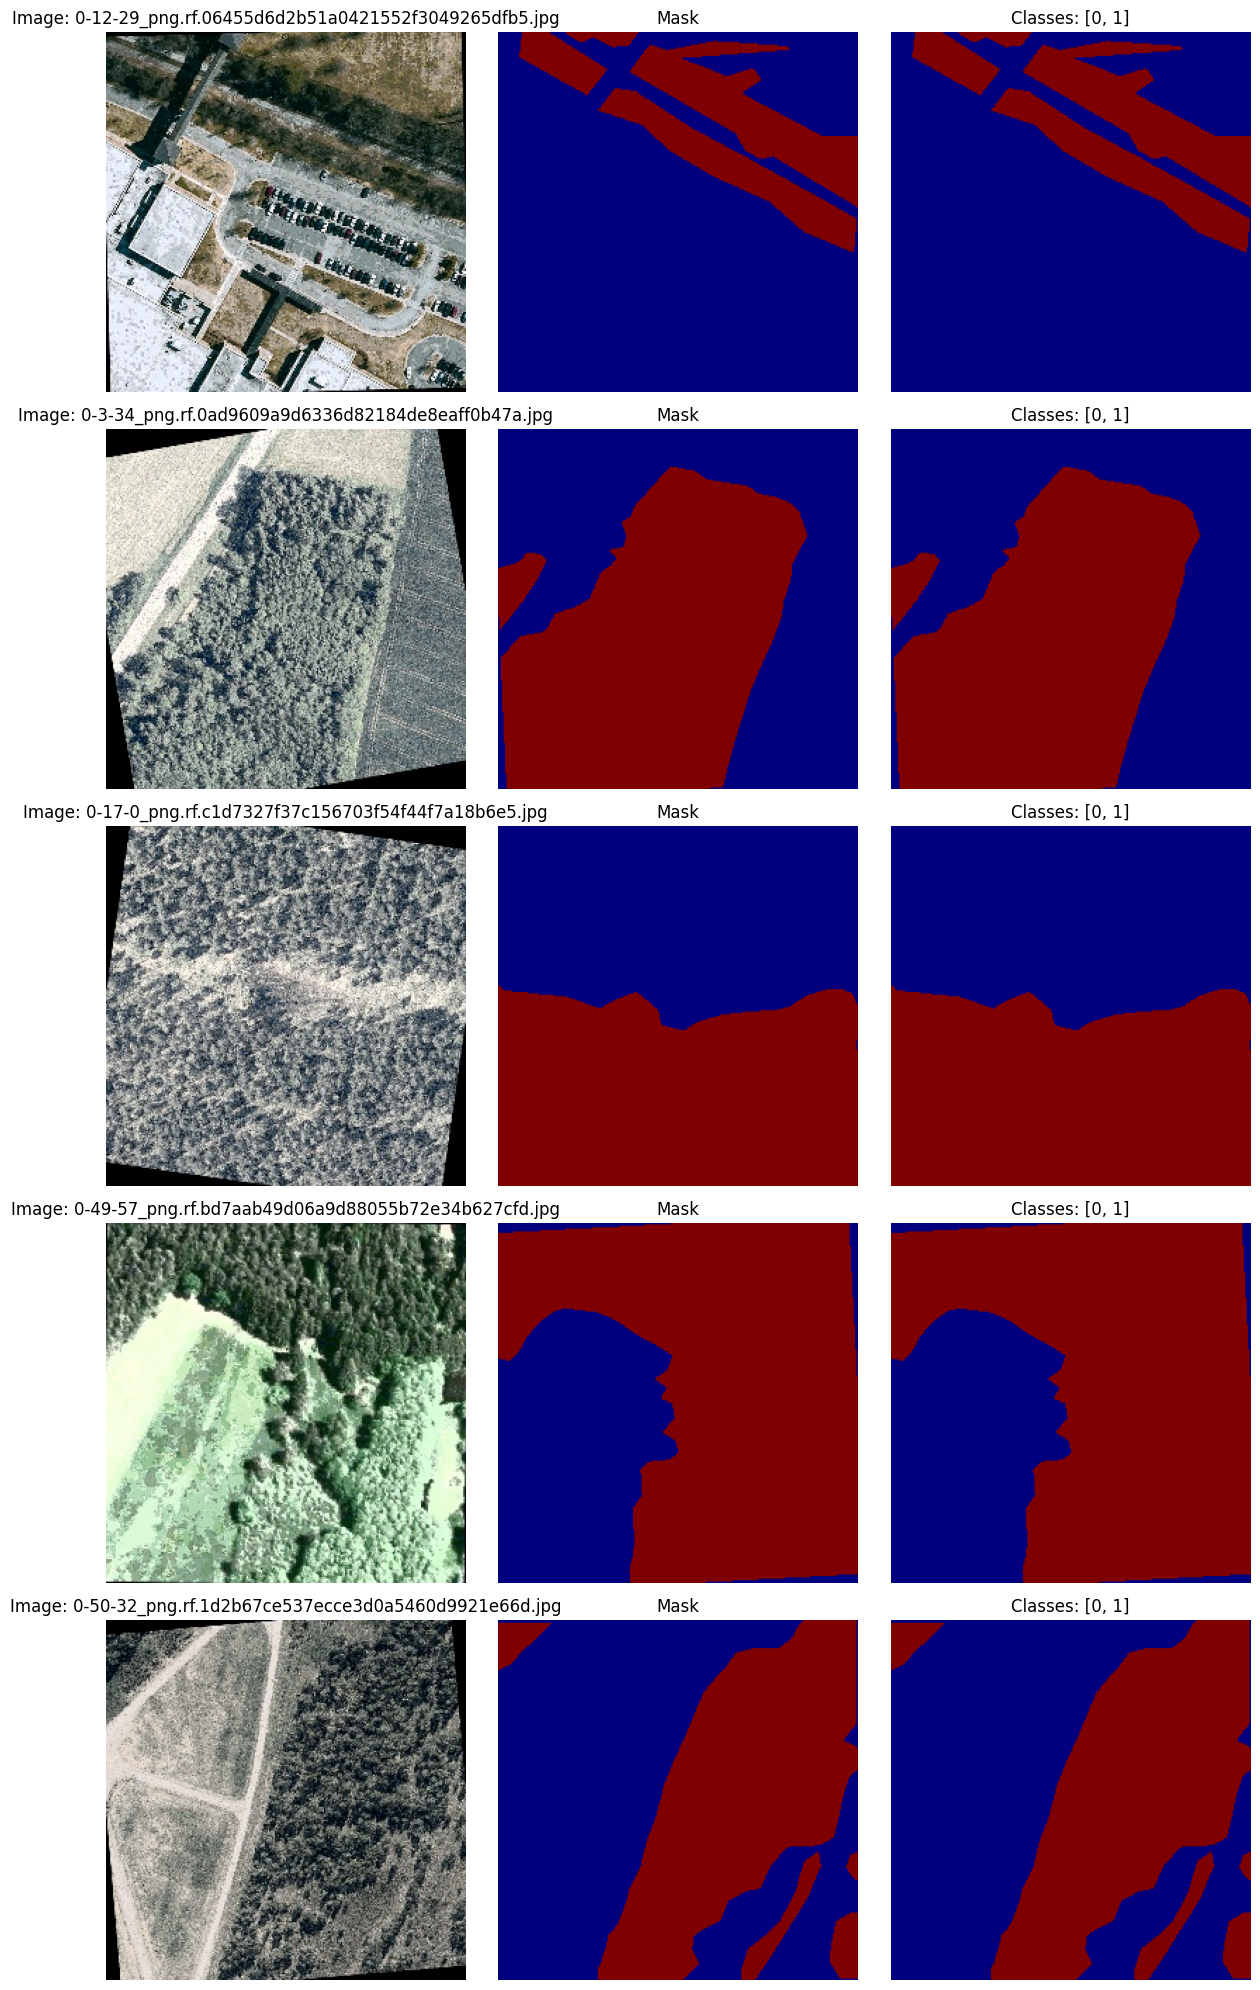

In [ ]:
proc_train_img = os.path.join(processed_root, "train", "images")
proc_train_mask = os.path.join(processed_root, "train", "masks")
files = [f for f in os.listdir(proc_train_img) if f.lower().endswith((".jpg",".jpeg",".png"))]
n_show = min(5, len(files))
indices = random.sample(range(len(files)), n_show)

plt.figure(figsize=(12, 4 * n_show))
plot_i = 1
for idx in indices:
    fn = files[idx]
    img = cv2.cvtColor(cv2.imread(os.path.join(proc_train_img, fn)), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(proc_train_mask, os.path.splitext(fn)[0] + ".png"), cv2.IMREAD_UNCHANGED)
    if mask is None:
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    unique = np.unique(mask)

    plt.subplot(n_show,3,plot_i); plt.imshow(img); plt.title(f"Image: {fn}"); plt.axis("off"); plot_i+=1
    plt.subplot(n_show,3,plot_i); plt.imshow(mask, cmap='jet'); plt.title("Mask"); plt.axis("off"); plot_i+=1
    plt.subplot(n_show,3,plot_i); plt.imshow(mask, cmap='jet'); plt.title(f"Classes: {unique.tolist()}"); plt.axis("off"); plot_i+=1
plt.tight_layout(); plt.show()

Class distribution (how many mask pixels per class and annotation counts)

In [ ]:
def class_distribution(mask_folder):
    files = [f for f in os.listdir(mask_folder) if f.lower().endswith(".png")]
    class_pixel_counts = {}
    class_image_counts = {}
    for fn in files:
        mask = cv2.imread(os.path.join(mask_folder, fn), cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue
        unique, counts = np.unique(mask, return_counts=True)
        for u,c in zip(unique,counts):
            u = int(u)
            class_pixel_counts[u] = class_pixel_counts.get(u,0) + int(c)
            class_image_counts[u] = class_image_counts.get(u,0) + 1
    return class_pixel_counts, class_image_counts

pix_cnt, img_cnt = class_distribution(os.path.join(processed_root, "train", "masks"))
print("\nClass pixel counts (train):", pix_cnt)
print("Class image counts (train):", img_cnt)


Class pixel counts (train): {0: 33200015, 1: 28731505}
Class image counts (train): {0: 944, 1: 828}


Prepare PyTorch Dataset & DataLoader for U-Net segmentation

In [ ]:
class SegDataset(Dataset):
    def __init__(self, img_folder, mask_folder):
        self.img_files = sorted([os.path.join(img_folder,f) for f in os.listdir(img_folder) if f.lower().endswith((".jpg",".jpeg",".png"))])
        self.mask_files = sorted([os.path.join(mask_folder,f) for f in os.listdir(mask_folder) if f.lower().endswith(".png")])
        # Keep equal lengths
        self.length = min(len(self.img_files), len(self.mask_files))
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        img = Image.open(self.img_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("L")
        img = np.array(img).astype(np.float32) / 255.0
        mask = np.array(mask).astype(np.int64)
        img = np.transpose(img, (2,0,1))
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

train_ds = SegDataset(os.path.join(processed_root,"train","images"), os.path.join(processed_root,"train","masks"))
val_ds   = SegDataset(os.path.join(processed_root,"valid","images"), os.path.join(processed_root,"valid","masks"))
test_ds  = SegDataset(os.path.join(processed_root,"test","images"),  os.path.join(processed_root,"test","masks"))

batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

print("\nDataset sizes (Segmentation): train/val/test =", len(train_ds), len(val_ds), len(test_ds))


Dataset sizes (Segmentation): train/val/test = 945 83 40


Lightweight U-Net model

In [ ]:
class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.Conv2d(32,32,3,padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        # bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.Conv2d(128,128,3,padding=1), nn.ReLU())
        # decoder
        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(64+64,64,3,padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        self.up2 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(32+32,32,3,padding=1), nn.ReLU(), nn.Conv2d(32,32,3,padding=1), nn.ReLU())
        self.final = nn.Conv2d(32,2,1)

    def forward(self, x):
        e1 = self.enc1(x)              # [B,32,H,W]
        e2 = self.enc2(nn.functional.max_pool2d(e1,2))  # [B,64,H/2,W/2]
        b  = self.bottleneck(nn.functional.max_pool2d(e2,2))  # [B,128,H/4,W/4]
        d1 = self.up1(b)              # [B,64,H/2,W/2]
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)             # [B,32,H,W]
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.final(d2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
unet = UNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

Using device: cuda


Metrics: IoU and Dice (per-class)

In [ ]:
def compute_iou_and_dice(pred_mask, true_mask, num_classes=2):
    ious = []
    dices = []
    for cls in range(num_classes):
        predc = (pred_mask==cls).astype(np.uint8)
        truec = (true_mask==cls).astype(np.uint8)
        inter = (predc & truec).sum()
        union = (predc | truec).sum()
        iou = inter/union if union>0 else 1.0
        dice = (2*inter)/(predc.sum()+truec.sum()) if (predc.sum()+truec.sum())>0 else 1.0
        ious.append(iou)
        dices.append(dice)
    return np.array(ious), np.array(dices)

Train U-Net

In [ ]:
epochs = 3
print("\nStarting U-Net training (epochs =", epochs, ")")
for epoch in range(epochs):
    unet.train()
    total_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = unet(imgs)               # [B,2,H,W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / max(1, len(train_loader))
    # quick val (limited to 10 batches for speed)
    unet.eval()
    iou_list=[]; dice_list=[]
    with torch.no_grad():
        for i, (vimgs, vmasks) in enumerate(val_loader):
            vimgs = vimgs.to(device)
            vmasks_np = vmasks.numpy()
            preds = unet(vimgs)
            preds = torch.argmax(preds, dim=1).cpu().numpy()
            for p,t in zip(preds, vmasks_np):
                ious, dices = compute_iou_and_dice(p, t, num_classes=2)
                iou_list.append(ious); dice_list.append(dices)
            if i >= 9:
                break
    mean_iou = np.mean(iou_list, axis=0) if len(iou_list)>0 else np.array([1.0,1.0])
    mean_dice = np.mean(dice_list, axis=0) if len(dice_list)>0 else np.array([1.0,1.0])
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Mean IoU: {mean_iou} - Mean Dice: {mean_dice}")

print("U-Net training finished. Saving weights to unet_small_soil.pth")
torch.save(unet.state_dict(), "unet_small_soil.pth")


Starting U-Net training (epochs = 3 )
Epoch 1/3 - Loss: 0.6836 - Mean IoU: [    0.42353     0.34997] - Mean Dice: [    0.56424     0.43719]
Epoch 2/3 - Loss: 0.6430 - Mean IoU: [    0.48909     0.34044] - Mean Dice: [    0.61899      0.4364]
Epoch 3/3 - Loss: 0.5818 - Mean IoU: [    0.58329     0.34273] - Mean Dice: [    0.68585     0.43328]
U-Net training finished. Saving weights to unet_small_soil.pth


Show 3 test predictions

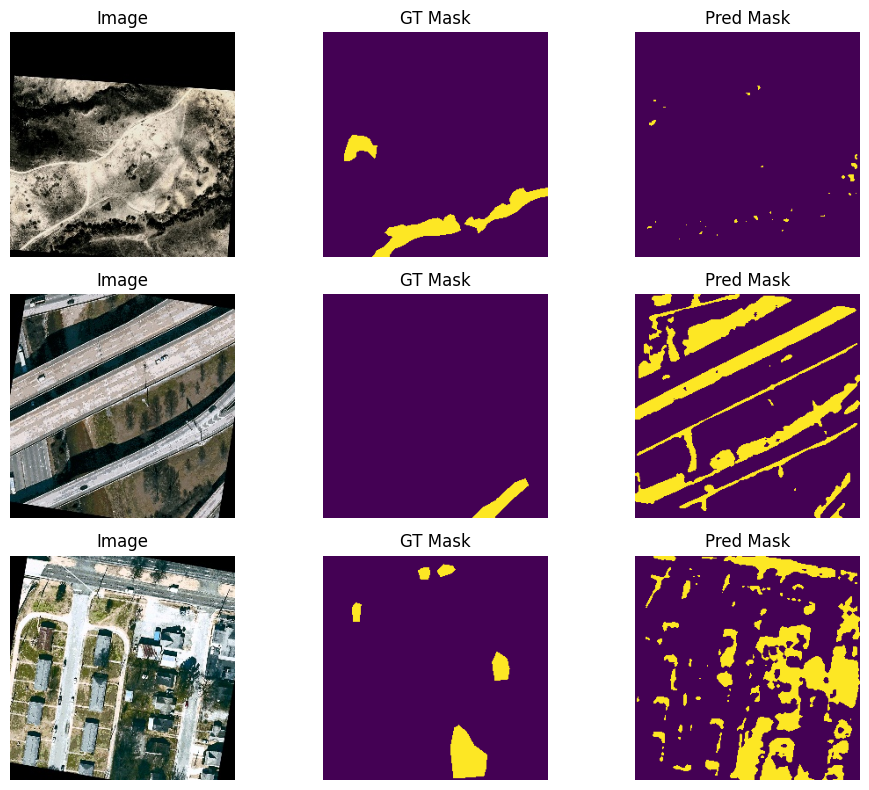

In [ ]:
unet.eval()
plt.figure(figsize=(10,8))
nvis = min(3, len(test_ds))
for i in range(nvis):
    img, mask = test_ds[i]
    with torch.no_grad():
        out = unet(img.unsqueeze(0).to(device))
        pred = torch.argmax(out, dim=1).squeeze().cpu().numpy()
    img_np = np.transpose(img.numpy(), (1,2,0))
    plt.subplot(nvis,3,i*3+1); plt.imshow(img_np); plt.title("Image"); plt.axis("off")
    plt.subplot(nvis,3,i*3+2); plt.imshow(mask.numpy()); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(nvis,3,i*3+3); plt.imshow(pred); plt.title("Pred Mask"); plt.axis("off")
plt.tight_layout(); plt.show()

YOLOv8n detection training

In [ ]:
print("\nStarting YOLOv8n training (detection). For speed we run few epochs.")
yolo = YOLO("yolov8n.pt")
# Use the Roboflow-generated data.yaml (already in dataset.location)
data_yaml = os.path.join(dataset.location, "data.yaml")
print("Using data.yaml:", data_yaml)
# Quick training - set epochs small (e.g., 10). Increase if you have GPU/time.
yolo.train(data=data_yaml, epochs=10, imgsz=640, batch=16, name="soil_yolov8n_quick")


Starting YOLOv8n training (detection). For speed we run few epochs.
Using data.yaml: /content/vegetation-segmentation-4/data.yaml
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/vegetation-segmentation-4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=Fal

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac32ea900e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

YOLO validation

In [ ]:
print("\nValidating YOLOv8 model (on validation set):")
yolo.val(data=data_yaml, imgsz=640)

print("\nAll steps finished. Summary:")
print("- Preprocessing done (256x256) and processed counts:", processed_counts)
print("- U-Net weights saved: unet_small_soil.pth")
print("- YOLOv8 training run name: soil_yolov8n_quick (check runs/)")


Validating YOLOv8 model (on validation set):
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2390.3±669.2 MB/s, size: 133.2 KB)
val: Scanning /content/vegetation-segmentation-4/valid/labels.cache... 83 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 83/83 178.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 2.0it/s 2.9s
                   all         83        205      0.692      0.504      0.609      0.405
Speed: 7.1ms preprocess, 6.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /content/runs/detect/val

All steps finished. Summary:
- Preprocessing done (256x256) and processed counts: {'train': 945, 'valid': 83, 'test': 40}
- U-Net weights saved: unet_small_soil.pth
- YOLOv8 training run name: soil_yolov8n_quick (check

In [ ]:
import shutil
from google.colab import files
import os

# Change this to the folder where your preprocessed data is stored
processed_root = os.path.join(dataset.location, "preprocessed")

# Zip the folder
zip_filename = "/content/preprocessed_dataset"
shutil.make_archive(zip_filename, 'zip', processed_root)

# Download the zip file
files.download(zip_filename + ".zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>